In [31]:
import os
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
serper_api_key = os.getenv("SERPER_API_KEY")
groq_api_key = os.getenv("GROQ_API_KEY")

In [2]:
tavily_key = os.getenv("tavily_key")

In [26]:
from langchain_community.chat_models import ChatOpenAI
llm = ChatOpenAI(model = "gpt-3.5-turbo",api_key=api_key)

In [18]:
llm.invoke("what is deep learning?")

AIMessage(content='Deep learning is a specialized subset of machine learning, which is a broader field within artificial intelligence (AI). It involves the use of neural networks with many layers of processing units, leveraging large amounts of data and computational power to model complex patterns and perform tasks. These tasks can range from image and speech recognition to language translation and game playing.\n\nHere are some key aspects of deep learning:\n\n1. **Neural Networks**: At the core of deep learning are artificial neural networks, which are inspired by the biological neural networks in human brains. These networks consist of nodes (or neurons) and edges that mimic the synaptic connections in a biological brain.\n\n2. **Layers**: Deep learning networks are characterized by their depth, which comes from having multiple layers of neurons. These layers are typically organized into three types:\n   - **Input Layer**: Accepts input features directly from the data.\n   - **Hidd

In [37]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="deepseek-r1-distill-llama-70b",api_key=groq_api_key)

In [33]:
llm.invoke("what is Data Science?").content

'<think>\n\n</think>\n\nData Science is an interdisciplinary field that extracts insights and knowledge from structured and unstructured data using various techniques, tools, and algorithms. It combines elements from computer science, statistics, machine learning, data analysis, and domain-specific knowledge to turn data into actionable information. The process typically involves:\n\n1. **Data Collection**: Gathering data from various sources.\n2. **Data Cleaning**: Ensuring the data is accurate, complete, and consistent.\n3. **Data Transformation**: Preparing and transforming data for analysis.\n4. **Data Analysis**: Using statistical and machine learning techniques to analyze data.\n5. **Data Visualization**: Presenting findings in a clear and understandable format.\n6. **Insight Generation**: Drawing meaningful conclusions from the data.\n7. **Decision Making**: Using insights to inform business decisions or solve problems.\n\nData Science is widely applied in industries like health

In [19]:
os.environ["TAVILY_API_KEY"] = tavily_key

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults
search = TavilySearchResults(max_results=5)

In [7]:
search.invoke("who is President of India?")

[{'title': 'President of India - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/President_of_India',
  'content': 'The president of India (ISO: Bhārata kē Rāṣṭrapati) is the head of state of the Republic of India. The president is the nominal head of the executive,[a] the first citizen of the country, as well as the supreme commander of the Indian Armed Forces. Droupadi Murmu is the 15th and current president, having taken office from 25 July 2022. [...] Jump to content\nMain menu\nSearch\nDonate\nCreate account\nLog in\nPersonal tools\nToggle the table of contents\nPresident of India\n70 languages\nArticle\nTalk\nRead\nView source\nView history\nTools\nFrom Wikipedia, the free encyclopedia\nFor a list of presidents, see List of presidents of India.\nPresident of India\nBhārata kē Rāṣṭrapati\nLogo of The President of India\nFlag of India\nIncumbent\nDroupadi Murmu\nsince\xa025 July 2022\nHead of state of the Republic of India\nExecutive branch of the Indian Government [...] making

In [ ]:
## this can be used as a tool

In [8]:
from typing import Annotated
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

In [9]:
repl = PythonREPL()

In [43]:
@tool
def python_repl_tool(
    code: Annotated[str,"The python code to execute to generate the chart"]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        
  
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )


In [10]:
def make_system_prompt(suffix:str) -> str:
    prompt = f""" You are a helpful AI assistant,collaborating with other assistants,
    Use the Provided tools to progress towards answering the question,if you are
    unable to fully answer the question then that's ok another assistant with other tool
    will help you where you left  off.Execute what you can to make progress.
    if you or any of the other assistant have the final answer or the deliverable,
    prefix your response with FINAL ANSWER so the team knows to stop.
    suffix:/n {suffix}"""
    return prompt


In [39]:
## importing the main packages
from typing import Literal
from langchain_core.messages import BaseMessage,HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import START,StateGraph,END,MessagesState
from langgraph.types import Command

In [12]:
def get_next_node(last_message:BaseMessage,goto:str):
    if "FINAL ANSWER" in last_message.content:
        return END
    return goto

In [ ]:
## now i will create the system where i will be making the research agent
## research agent will do search from web search based on the provided question

In [38]:
## creating the react agent for research agent
research_agent = create_react_agent(
    llm,
    tools = [search],
    prompt=make_system_prompt(
        "You can only do research,you are working with your colleague chart generator"
    )
)

In [40]:
from langgraph.graph import END

In [ ]:
## creating the research node
def research_node(state:MessagesState) -> Command[Literal["chart_generator",END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1],"chart_generator")
    result["messages"][-1] = HumanMessage(
        content = result["messages"][-1].content,name = "researcher"
    )
    return Command(
        update = {"messages":result["messages"]},
        goto=goto
    )

In [44]:
## now creating the chart generator system
## first creting the react agent
chart_gen = create_react_agent(
    llm,
    tools = [python_repl_tool],
    prompt = make_system_prompt("you are chart generator,you are working with your colleague ")
)

In [56]:
def chart_generator(state:MessagesState) -> Command[Literal["researcher",END]]:
    result = chart_gen.invoke(state)
    goto = get_next_node(result["messages"][-1],"researcher")
    result["messages"][-1] = HumanMessage(
        content = result["messages"][-1],name = "chart_generator"
    )
    return Command(
        update = {"messages":result["messages"]},
        goto=goto
    )

In [59]:
## creating the workflow for multi agnet netwrok architecture system
workflow = StateGraph(MessagesState)
workflow.add_node("researcher",research_node)
workflow.add_node("chart_generator",chart_generator)
workflow.add_edge(START,"researcher")
graph = workflow.compile()


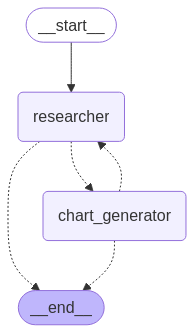

In [60]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

{'researcher': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='f8a64658-e42a-40b0-b118-981398ba25b3'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_d21b', 'function': {'arguments': '{"query":"UK GDP past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 539, 'prompt_tokens': 304, 'total_tokens': 843, 'completion_time': 1.96, 'prompt_time': 0.014290295, 'queue_time': 0.053693135999999995, 'total_time': 1.9742902949999999}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_2834edf0f4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4f38a2e2-c5c0-421b-a706-71e6b48cc1fb-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP past 5 years'}, 'id': 'call_d21b', 'type': 'tool_call'}], us

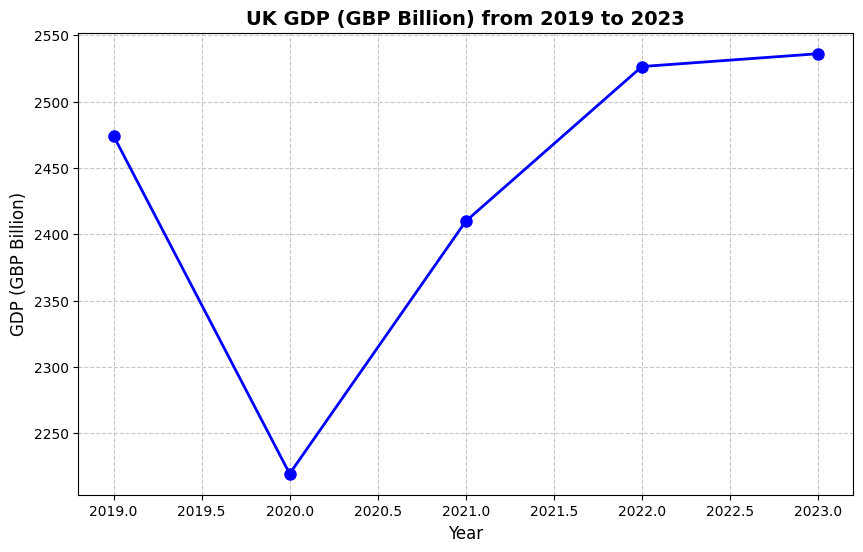

ValidationError: 21 validation errors for HumanMessage
content.str
  Input should be a valid string [type=string_type, input_value=AIMessage(content="Here i..., 'total_tokens': 4081}), input_type=AIMessage]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].0.str
  Input should be a valid string [type=string_type, input_value=('content', "Here is the ...sentation of the data."), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].0.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('content', "Here is the ...sentation of the data."), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].1.str
  Input should be a valid string [type=string_type, input_value=('additional_kwargs', {}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].1.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('additional_kwargs', {}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].2.str
  Input should be a valid string [type=string_type, input_value=('response_metadata', {'t...top', 'logprobs': None}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].2.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('response_metadata', {'t...top', 'logprobs': None}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].3.str
  Input should be a valid string [type=string_type, input_value=('type', 'ai'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].3.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('type', 'ai'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].4.str
  Input should be a valid string [type=string_type, input_value=('name', None), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].4.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('name', None), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].5.str
  Input should be a valid string [type=string_type, input_value=('id', 'run-c7e58511-6134...8c-a2bf-ad9c6e7d8481-0'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].5.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('id', 'run-c7e58511-6134...8c-a2bf-ad9c6e7d8481-0'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].6.str
  Input should be a valid string [type=string_type, input_value=('example', False), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].6.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('example', False), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].7.str
  Input should be a valid string [type=string_type, input_value=('tool_calls', []), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].7.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('tool_calls', []), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].8.str
  Input should be a valid string [type=string_type, input_value=('invalid_tool_calls', []), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].8.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('invalid_tool_calls', []), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].9.str
  Input should be a valid string [type=string_type, input_value=('usage_metadata', {'inpu..., 'total_tokens': 4081}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].9.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('usage_metadata', {'inpu..., 'total_tokens': 4081}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type

In [63]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the UK's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

In [64]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the UK's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'researcher': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='e5b3fd08-d9b3-45a2-9f2f-7cee4bb1d6eb'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ref4', 'function': {'arguments': '{"query":"UK GDP past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 181, 'prompt_tokens': 304, 'total_tokens': 485, 'completion_time': 0.658181818, 'prompt_time': 0.017360587, 'queue_time': 0.722331618, 'total_time': 0.675542405}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_fc872c073e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a6588109-c12a-479a-8fb1-ee1fba906522-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP past 5 years'}, 'id': 'call_ref4', 'type': 'tool_call'}], usage_metad